We will fine-tune a BERT model on our dataset to classify a tweet into one of the 2 classes. The code has the following sections:
1. Necessary Imports
2. Dataloader
3. Split data into Train and Validation sets
4. Model Definition
5. Trainer and Inference
6. Set Hyperparameters
7. Start Training
8. Visualize the statistics (Loss, Accuracy)
9. Predict and generate submission.csv

Accuracy on Test set - **81.673%**


### Install and Import necessary modules

In [160]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
import seaborn as sns
from collections import defaultdict
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [157]:
# Select CPU/GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Dataloader

In [140]:
'''
Load the BERT tokenizer.
'''
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


'''
Dataloader 
For Training: Returns (Tweet, Input_id, Attention_mask, label)
For Testing: Returns (Tweet, Input_id, Attention_mask)
'''
class mydataset():    

    def __init__(self, classification_df, name = 'train'):

        super(mydataset).__init__()
        self.name = name
        self.tweet = []
        self.Y = []
                    
        for index,rows in classification_df.iterrows():

            tweet = rows['keyword'] + rows['location'] + rows['text']
            self.tweet.append(''.join(tweet)) 
            
            if name == 'train' or self.name == 'valid':
                label = rows['target']
                self.Y.append(label)

        
        
        '''
        Tokenize all of the captions and map the tokens to thier word IDs, and get respective attention masks.
        '''
        self.input_ids, self.attention_masks = tokenize(self.tweet)
        
        
    
    def __getitem__(self,index): 
        '''
        For Captions, Input ids and Attention mask
        '''
        tweet = self.tweet[index]
        input_id = self.input_ids[index]
        attention_masks = self.attention_masks[index]
        
        
        '''
        For Labels during training
        '''      
        if self.name == 'train' or self.name == 'valid' :
            label = float(self.Y[index])
            
            return tweet, input_id, attention_masks, torch.as_tensor(label).long()

        
        else:
            return tweet, input_id, attention_masks
        
        
  
    def __len__(self):
        return len(self.tweet)
    
    
            
'''
tokenize all of the sentences and map the tokens to their word IDs.
'''

def tokenize(sequences):
    
    input_ids = []
    attention_masks = []

    # For every caption...
    for seq in sequences:
        
        encoded_dict = tokenizer.encode_plus(
                            seq,                       # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 32,           # Pad & truncate all sentences.
                            truncation=True,
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',      # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    
    return input_ids, attention_masks


In [141]:
'''
Shuffle and split 10 percent data for Validation set
'''
train_csv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', keep_default_na = False)
train_csv = train_csv.sample(frac=1).reset_index(drop=True)
ninetyfive_percent  = round(0.90*(len(train_csv)))
train_data = train_csv.iloc[:ninetyfive_percent]
valid_data = train_csv.iloc[ninetyfive_percent:]

print('Number of Training samples: ', len(train_data))
print('Number of Validation samples: ',len(valid_data))

Number of Training samples:  6852
Number of Validation samples:  761


In [142]:
'''
Train Dataloader
''' 
train_dataset = mydataset(train_data, name = 'train')
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)


'''
Validation_Dataloader
'''
validation_dataset = mydataset(valid_data, name = 'valid')
validation_dataloader = data.DataLoader(validation_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)

In [143]:
'''
Test Dataloader
''' 
test_csv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', keep_default_na = False)
test_dataset = mydataset(test_csv , name = 'test')          
test_dataloader = data.DataLoader(test_dataset, shuffle= False, batch_size = 1, num_workers=16,pin_memory=True)

# Model Definition

In [152]:
'''
Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
''' 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #12-layer BERT model, with an uncased vocab.
    num_labels = 2, #Number of Classes
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Trainer

In [145]:
def train(model, data_loader, valid_loader, criterion, optimizer, lr_scheduler, modelpath, device, epochs):
    
    model.train()

    train_loss= []
    valid_loss = []
    valid_acc = []


    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (tweet, input_id, attention_masks, target) in enumerate(data_loader):
            
            input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)
                
            '''
            Compute output and loss from BERT
            '''
            loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=attention_masks, 
                             labels=target,
                             return_dict=False
                                )

            '''
            Take Step
            '''                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            '''
            Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
            '''
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            
            avg_loss += loss.item()

            '''
            linear_schedule_with_warmup take step after each batch
            '''
            lr_scheduler.step()
                                
            
        training_loss = avg_loss/len(data_loader)
       
        print('Epoch: ', epoch+1)            
        print('training loss = ', training_loss)
        train_loss.append(training_loss)

        '''
        Check performance on validation set after an Epoch
        '''
        validation_loss, top1_acc= test_classify(model, valid_loader, criterion, device)
        valid_loss.append(validation_loss)
        valid_acc.append(top1_acc)

         
        '''
        save model checkpoint after every epoch
        '''
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            }, modelpath)
        
    return train_loss, valid_loss, valid_acc






'''
Function to perform inference on validation set
Returns: validation loss, top1 accuracy
'''

def test_classify(model, valid_loader, criterion, device):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    total = 0

    for batch_num, (tweet, input_id, attention_masks, target) in enumerate(valid_loader):
               
        input_ids, attention_masks, target = input_id.to(device), attention_masks.to(device), target.to(device)
            
        '''
        Compute output and loss from BERT
        '''
        loss, logits = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks, 
                         labels=target,
                         return_dict=False)

        test_loss.extend([loss.item()]*input_id.size()[0])
        
        predictions = F.softmax(logits, dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, target)).item()
        total += len(target)

    print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}'.format(np.mean(test_loss), top1_accuracy/total))
        
    return np.mean(test_loss), top1_accuracy/total

# Hyperparameters


In [153]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()

'''
Optimizer
'''
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

'''
Number of training epochs. The BERT authors recommend between 2 and 4. Increasing the number of epochs with BERT will increase overfitting the training set, as it can be seen from the loss plot later.
'''
num_Epochs = 4

'''
Create the learning rate scheduler.
Total number of training steps is [number of batches] x [number of epochs].
'''
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

# Time to start training

In [154]:
modelname = 'BERT'
modelpath = 'saved_checkpoint_'+modelname

train_loss, valid_loss, valid_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, device, epochs = num_Epochs)

Epoch:  1
training loss =  0.48097548588763833
Test Loss: 0.3921	Top 1 Test Accuracy: 0.8371


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch:  2
training loss =  0.34684102542178574
Test Loss: 0.4005	Top 1 Test Accuracy: 0.8384
Epoch:  3
training loss =  0.23150466845132583
Test Loss: 0.4267	Top 1 Test Accuracy: 0.8318
Epoch:  4
training loss =  0.12313524123367875
Test Loss: 0.5389	Top 1 Test Accuracy: 0.8173
Epoch:  5
training loss =  0.061653812502532504
Test Loss: 0.6849	Top 1 Test Accuracy: 0.8305
Epoch:  6
training loss =  0.04050451455865228
Test Loss: 0.7698	Top 1 Test Accuracy: 0.8357
Epoch:  7
training loss =  0.029047359382397994
Test Loss: 0.8467	Top 1 Test Accuracy: 0.8226
Epoch:  8
training loss =  0.0193997336843939
Test Loss: 0.9240	Top 1 Test Accuracy: 0.8160
Epoch:  9
training loss =  0.016001142176046836
Test Loss: 0.9336	Top 1 Test Accuracy: 0.8292
Epoch:  10
training loss =  0.013920199744630778
Test Loss: 0.9367	Top 1 Test Accuracy: 0.8292


# Visualize Loss and Accuracy plots

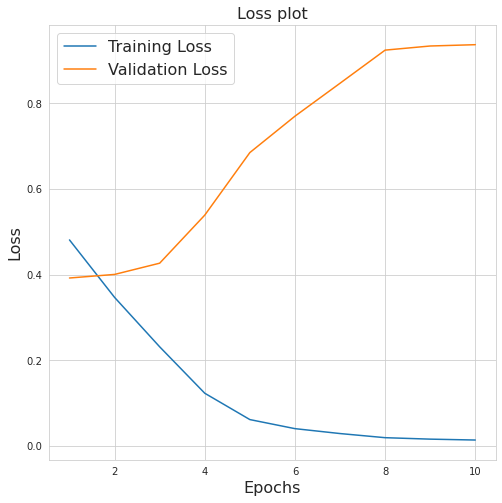

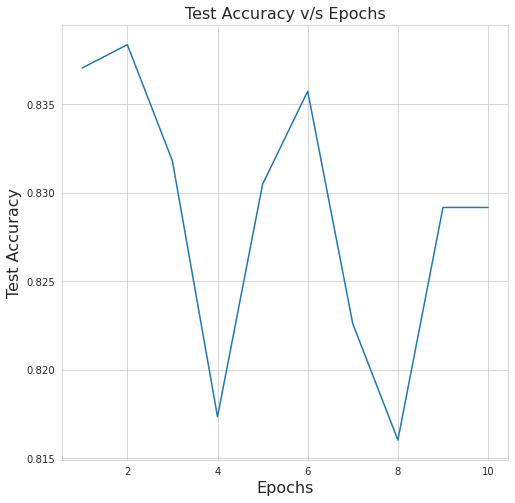

In [161]:
def plot_loss(epochs, train_loss, test_loss, title):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, train_loss, label = 'Training Loss')
    plt.plot(x, test_loss, label = 'Validation Loss')
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Loss', fontsize =16)
    plt.title(title,fontsize =16)
    plt.legend(fontsize=16)
    
    
def plot_acc(epochs,test_acc):
    plt.figure(figsize=(8,8))
    x = np.arange(1,epochs+1)
    plt.plot(x, test_acc)
    plt.xlabel('Epochs', fontsize =16)
    plt.ylabel('Test Accuracy', fontsize =16)
    plt.title('Test Accuracy v/s Epochs',fontsize =16)
    
    
sns.set_style("whitegrid")
plot_loss(num_Epochs, train_loss, valid_loss, title='Loss plot')
plot_acc(num_Epochs, valid_acc)

# Predict and generate submission.csv

In [162]:
def predict(model, test_loader, device):
    model.eval()
    target = []
    for batch_num, (captions, input_id, attention_masks) in enumerate(test_loader):
     
        
        input_ids, attention_masks = input_id.to(device), attention_masks.to(device)
            
        '''
        Compute prediction outputs from BERT
        '''
        output_dictionary = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks, 
                         return_dict=True)
        
        predictions = F.softmax(output_dictionary['logits'], dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.item()        
        target.append(top1_pred_labels)
        
        
    make_csv(target)
        

def make_csv(target):
    test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
    my_submission = pd.DataFrame({'id': test.id, 'target': target})
    my_submission.to_csv('submission.csv', index=False)
    

In [163]:
predict(model, test_dataloader, device)